In [29]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os
import sys
assert sys.version_info >= (3, 5)

from pathlib import Path
from pprint import pprint
import glob
import shutil
import itertools
import pandas as pd
import numpy as np
from typing import List, Optional, Union

import tensorflow as tf
from tensorflow import keras
print(tf.__version__)
# assert tf.__version__ >= "2.0"
# print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
AUTO     = tf.data.experimental.AUTOTUNE

from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.utils import plot_model

from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input, Dense, Dropout, Activation, BatchNormalization
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.models import Sequential, Model

# To plot pretty figures
# import matplotlib as mpl
import matplotlib.pyplot as plt
# mpl.rc('axes', labelsize=14)
# mpl.rc('xtick', labelsize=12)
# mpl.rc('ytick', labelsize=12)

import cv2
import openslide

# Seed
np.random.seed(42)

fdir = Path.cwd()
print(fdir)
sys.path.append(str(fdir/'../src'))
from config import cfg

# # from deephistopath.wsi import filter
from deephistopath.wsi import slide
# # from deephistopath.wsi import tiles
from deephistopath.wsi import util

from build_tfrec import show_img  # (show_images, encode_categorical, np_img_to_bytes)
from train_nn import get_tfr_files
from tf_utils import (calc_records_in_tfr_folder, calc_examples_in_tfrecord,
                      _float_feature, _bytes_feature, _int64_feature)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
2.3.1
/vol/ml/apartin/projects/pdx-histo/nbs


In [30]:
# Global (my data)
# MAIN_APPDIR = fdir/'../apps'
# DATADIR = fdir/'../data'
# ANNOTATIONS_FILENAME = 'annotations.csv'
# TILES_DIR = DATADIR/'tiles_png'
# TFR_DIR = DATADIR/'tfrecords'

APPNAME = 'bin_ctype_balanced_01'

In [31]:
cfg

namespace(MAIN_APPDIR=PosixPath('/vol/ml/apartin/projects/pdx-histo/src/../apps'),
          DATADIR=PosixPath('/vol/ml/apartin/projects/pdx-histo/src/../data'),
          TILES_DIR=PosixPath('/vol/ml/apartin/projects/pdx-histo/src/../data/tiles_png'),
          ANNOTATIONS_FILENAME='annotations.csv',
          SF_ANNOTATIONS_FILENAME='annotations_slideflow.csv',
          TFR_DIR=PosixPath('/vol/ml/apartin/projects/pdx-histo/data/tfrecords'),
          SF_TFR_DIR=PosixPath('/vol/ml/apartin/projects/pdx-histo/src/../../slideflow-proj/PDX_FIXED/299px_302um'),
          BAD_SLIDES=[45983, 83742, 83743, 22232, 21836, 20729])

# Load data

In [32]:
# Path
# tiles_path = DATADIR/'tiles_png'
# tfr_path = DATADIR/'tfrecords'

# Load data
appdir = cfg.MAIN_APPDIR/APPNAME
annotations_file = appdir/cfg.SF_ANNOTATIONS_FILENAME
data = pd.read_csv(annotations_file)
print(data.shape)

display(data.groupby(['ctype', 'ctype_label', 'Response']).agg({'smp': 'nunique'}).reset_index().rename(columns={'smp': 'samples'}))

(126, 2612)


,ctype,ctype_label,Response,samples
0,digestive/gastrointestinal,1,0,60
1,digestive/gastrointestinal,1,1,3
2,squamous,0,0,63


In [33]:
# Read data
# data = pd.read_csv(datapath/'data_merged.csv')
# csite_enc = encode_categorical(df=data, label_name='csite', label_value='csite_label')
# ctype_enc = encode_categorical(df=data, label_name='ctype', label_value='ctype_label')
# CSITE_NUM_CLASSES = len(csite_enc.keys())
# CTYPE_NUM_CLASSES = len(ctype_enc.keys())

GE_LEN = sum([1 for c in data.columns if c.startswith('ge_')])
DD_LEN = sum([1 for c in data.columns if c.startswith('dd_')])

In [34]:
# Feature specs (used to read an example from tfrecord)
FEA_SPEC = {
    'ge_vec': tf.io.FixedLenFeature(shape=(GE_LEN,), dtype=tf.float32, default_value=None),
    'dd_vec': tf.io.FixedLenFeature(shape=(DD_LEN,), dtype=tf.float32, default_value=None),    
    
    'smp':      tf.io.FixedLenFeature(shape=[], dtype=tf.string, default_value=None), 
    'Response': tf.io.FixedLenFeature(shape=[], dtype=tf.int64, default_value=None), 
    'image_id': tf.io.FixedLenFeature(shape=[], dtype=tf.int64, default_value=None), 
    
    'image_raw': tf.io.FixedLenFeature(shape=[], dtype=tf.string, default_value=None),
    
    'tile_id': tf.io.FixedLenFeature(shape=[], dtype=tf.string, default_value=None),
    'row':     tf.io.FixedLenFeature(shape=[], dtype=tf.string, default_value=None),
    'col':     tf.io.FixedLenFeature(shape=[], dtype=tf.string, default_value=None),    
    
    'Sample': tf.io.FixedLenFeature(shape=[], dtype=tf.string, default_value=None),
    'ctype':  tf.io.FixedLenFeature(shape=[], dtype=tf.string, default_value=None),
    'csite':  tf.io.FixedLenFeature(shape=[], dtype=tf.string, default_value=None),    
    'ctype_label':  tf.io.FixedLenFeature(shape=[], dtype=tf.int64, default_value=None),
    'csite_label':  tf.io.FixedLenFeature(shape=[], dtype=tf.int64, default_value=None),
}

In [36]:
# Summary of tfrecords
tfr_files = sorted(cfg.TFR_DIR.glob('*.tfrec*'))
print('Number of tfrecords the folder:', len(tfr_files))
# calc_records_in_tfr_folder(tfr_dir=TFR_DIR)
calc_examples_in_tfrecord(tfr_path=str(tfr_files[0]))

Number of tfrecords the folder: 0


IndexError: list index out of range

In [7]:
# -----------------------------------------------
#       Data splits
# -----------------------------------------------
# T/V/E filenames
splitdir = appdir/'splits'
split_id = 0

split_pattern = f'1fold_s{split_id}_*_id.csv'
single_split_files = glob.glob(str(splitdir/split_pattern))
# single_split_files = list(splitdir.glob(split_pattern))

# Get indices for the split
# assert len(single_split_files) >= 2, f'The split {s} contains only one file.'
for id_file in single_split_files:
    if 'tr_id' in id_file:
        tr_id = pd.read_csv(id_file).values.reshape(-1,)
    elif 'vl_id' in id_file:
        vl_id = pd.read_csv(id_file).values.reshape(-1,)
    elif 'te_id' in id_file:
        te_id = pd.read_csv(id_file).values.reshape(-1,)

cv_lists = (tr_id, vl_id, te_id)

# -----------------------------------------------
#       Get data based on splits
# -----------------------------------------------
# Dfs of T/V/E samples
tr_df = data.iloc[tr_id, :].reset_index(drop=True)
vl_df = data.iloc[vl_id, :].reset_index(drop=True)
te_df = data.iloc[te_id, :].reset_index(drop=True)
print('Total samples {}'.format(tr_df.shape[0] + vl_df.shape[0] + te_df.shape[0]))

# List of sample names for T/V/E
tr_smp_names = list(tr_df['smp'].values)
vl_smp_names = list(vl_df['smp'].values)
te_smp_names = list(te_df['smp'].values)
print('Total samples {}'.format(len(tr_smp_names) + len(vl_smp_names) + len(te_smp_names)))

# x_data = data.iloc[idx, :].reset_index(drop=True)
# y_data = np.squeeze(ydata.iloc[idx, :]).reset_index(drop=True)

tr_tfr_files = get_tfr_files(tr_smp_names)
vl_tfr_files = get_tfr_files(vl_smp_names)
te_tfr_files = get_tfr_files(te_smp_names)
print('Total samples {}'.format(len(tr_tfr_files) + len(vl_tfr_files) + len(te_tfr_files)))

Total samples 123
Total samples 123
Total samples 123


In [8]:
# Missing tfrecords
print('\nThese samples miss a tfrecord ...\n')
data.loc[~data.smp.isin(tr_smp_names + vl_smp_names + te_smp_names), ['smp', 'image_id']]


These samples miss a tfrecord ...



,smp,image_id
8,521955~158-R3~FY4DV1F55GP1_NSC.758246,35584
30,172845~121-T~M776M1155J93_NSC.362856,16343
48,197837~219-T~E00_NSC.19893,16331


Feature types in the tfrecord example:
dict_keys(['Response', 'Sample', 'col', 'csite', 'csite_label', 'ctype', 'ctype_label', 'dd_vec', 'ge_vec', 'image_id', 'image_raw', 'row', 'smp', 'tile_id'])

Bytes (tile_id):
b'33679_1'

Bytes (ctype):
b'digestive/gastrointestinal'

Float (ctype_label):
tf.Tensor(1, shape=(), dtype=int64)

Int (Response):
tf.Tensor(0, shape=(), dtype=int64)

Float (ge_vec):
tf.Tensor([9.757551  6.2210474 7.069688  9.370674 ], shape=(4,), dtype=float32)

Bytes (image_raw):
tf.Tensor([303 303   3], shape=(3,), dtype=int32)
(303, 303, 3)


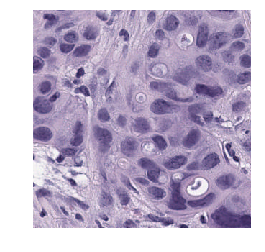

In [9]:
# -----------------------------------------------
# Read single tfrecord and explore single example
# -----------------------------------------------

ds = tf.data.TFRecordDataset(te_tfr_files[0])
ex = next(ds.__iter__())
ex = tf.io.parse_single_example(ex, features=FEA_SPEC)  # returns features for a given example in a dict
print('Feature types in the tfrecord example:\n{}'.format(ex.keys()))

# Bytes
print('\nBytes (tile_id):')
print(ex['tile_id'].numpy())
# print(ex['tile_id'].numpy().decode('utf-8'))

# Bytes
print('\nBytes (ctype):')
print(ex['ctype'].numpy())
# print(ex['csite'].numpy().decode('utf-8'))

# Float
print('\nFloat (ctype_label):')
print(ex['ctype_label'])
# print(ex['csite_label'].numpy())

# Int
print('\nInt (Response):')
print(ex['Response'])
# print(ex['Response'].numpy())

# Float
print('\nFloat (ge_vec):')
print(ex['ge_vec'][:4])
# print(ex['ge_vec'].numpy()[:4])

# Bytes
print('\nBytes (image_raw):')
img = tf.image.decode_jpeg(ex['image_raw'], channels=3)
print(tf.shape(img))
print(img.numpy().shape)

# util.np_to_pil(img.numpy())
show_img(img.numpy())

In [10]:
ct_list = []
ctl_list = []
im_list = []
id_list = []

# All tfrecord
ds = tf.data.TFRecordDataset(te_tfr_files)

# ds = tf.data.Dataset.from_tensor_slices(te_tfr_files)
# ds = ds.interleave(lambda x: tf.data.TFRecordDataset(x), cycle_length=4)

# Subset of tfrecords
# ds = tf.data.TFRecordDataset(te_tfr_files[0])  # label 1 (digestive/gastrointestinal)
# ds = tf.data.TFRecordDataset(te_tfr_files[2])  # label 10 (squamous)
# ds = tf.data.TFRecordDataset(te_tfr_files[:3])  # get 3 tfrecords

ds = ds.shuffle(buffer_size=300, seed=None)  # this shuffles the items within ALL the loaded tfrecords

# Iterate over all elements of the tfrecords
for i, ex in enumerate(ds):
    ex = tf.io.parse_single_example(ex, features=FEA_SPEC)
    im_list.append(ex['image_raw'].numpy())
    ct_list.append(ex['ctype'].numpy())
    ctl_list.append(ex['ctype_label'].numpy())
    id_list.append(ex['tile_id'].numpy())

print('Number of files:   ', len(te_tfr_files))
print('Number of elements:', len(ct_list))
print('Unique ctypes:     ', np.unique(ct_list))
print('bincount:          ', np.bincount(ctl_list))
print('\nctype label:\n{}'.format(ctl_list))
print('\ntile id:\n{}'.format(id_list[:10]))

Number of files:    12
Number of elements: 600
Unique ctypes:      [b'digestive/gastrointestinal' b'squamous']
bincount:           [  0 300   0   0   0   0   0   0   0   0 300]

ctype label:
[1, 1, 1, 10, 1, 1, 1, 1, 1, 1, 1, 10, 10, 1, 10, 1, 1, 1, 1, 1, 10, 1, 10, 1, 1, 10, 1, 1, 1, 10, 10, 1, 10, 1, 1, 1, 1, 10, 10, 1, 10, 1, 10, 1, 1, 10, 10, 10, 1, 10, 1, 1, 1, 10, 10, 10, 10, 1, 1, 1, 1, 1, 1, 10, 10, 1, 1, 1, 10, 1, 10, 1, 1, 10, 1, 10, 10, 10, 1, 1, 1, 1, 1, 10, 1, 1, 1, 10, 10, 10, 10, 1, 10, 1, 10, 10, 10, 1, 1, 1, 1, 10, 1, 1, 1, 1, 1, 1, 1, 1, 1, 10, 1, 10, 1, 10, 1, 1, 10, 1, 1, 1, 1, 10, 10, 1, 10, 10, 1, 1, 10, 10, 1, 1, 1, 1, 1, 1, 10, 10, 10, 1, 1, 1, 1, 10, 10, 1, 10, 10, 10, 1, 10, 10, 10, 1, 1, 10, 10, 1, 1, 10, 1, 1, 1, 1, 10, 1, 1, 10, 1, 1, 10, 1, 1, 1, 10, 10, 1, 1, 10, 10, 1, 10, 1, 1, 1, 10, 1, 10, 1, 1, 1, 1, 1, 1, 1, 1, 10, 1, 1, 1, 1, 10, 10, 10, 10, 10, 1, 1, 10, 1, 1, 10, 10, 10, 10, 1, 1, 1, 1, 1, 10, 10, 10, 1, 10, 10, 10, 10, 1, 1, 1, 1, 10, 1, 10, 1, 

# Suggestions on data loading pipeline
- https://github.com/tensorflow/tensorflow/issues/14857 
- https://github.com/jkjung-avt/keras_imagenet/blob/master/utils/dataset.py
- https://jkjung-avt.github.io/tfrecords-for-keras/

In [11]:
# # ----------------------
# # The effect of repeat()
# # ----------------------
# sub_files = vl_tfr_files[:4]

# # One repeat
# print('\nOne repeat:')
# repeat = 1
# shards = tf.data.Dataset.from_tensor_slices(sub_files)
# shards = shards.repeat(repeat)
# _ = [print(f) for i, f in enumerate(shards)]

# # Two repeat
# print('\nTwo repeats:')
# repeat = 2
# shards = tf.data.Dataset.from_tensor_slices(sub_files)
# shards = shards.repeat(repeat)
# _ = [print(f) for i, f in enumerate(shards)]

In [12]:
# # -----------------------
# # The effect of shuffle()
# # -----------------------
# sub_files = vl_tfr_files[:8]
# buffer_size = 2
# # buffer_size = len(sub_files)
# repeat = 1
# seed = 0

# print('\nWithout shuffle (one repeat):')
# shards = tf.data.Dataset.from_tensor_slices(sub_files)
# shards = shards.repeat(repeat)
# _ = [print(f) for i, f in enumerate(shards)]

# print('\nWith shuffle (buffer_size=2) (one repeat):')
# shards = tf.data.Dataset.from_tensor_slices(sub_files)
# shards = shards.repeat(repeat)
# shards = shards.shuffle(buffer_size=buffer_size, seed=seed)
# _ = [print(f) for i, f in enumerate(shards)]

In [13]:
# # https://github.com/tensorflow/tensorflow/issues/14857 
# sub_files = te_tfr_files

# # 1. Randomly shuffle the entire data once using a MapReduce/Spark/Beam/etc. job
# #    to create a set of roughly equal-sized files ("shards").
# shards = tf.data.Dataset.from_tensor_slices(te_tfr_files)  # data shards

# # 2. In each epoch:
# # i. Randomly shuffle the list of shard filenames, using Dataset.list_files(...).shuffle(num_shards).
# shards = shards.shuffle(len(sub_files), seed=None)
# # shards = shards.repeat()

# # ii. Use dataset.interleave(lambda filename: tf.data.TextLineDataset(filename), cycle_length=N)
# #     to mix together records from N different shards.
# dataset = shards.interleave(lambda x: tf.data.TFRecordDataset(x), cycle_length=4)

# # iii. Use dataset.shuffle(B) to shuffle the resulting dataset. Setting B might require some experimentation,
# #      but you will probably want to set it to some value larger than the number of records in a single shard.
# dataset = dataset.shuffle(buffer_size=512)  # (ap) this shuffles the examples in the relevant filenames

# _ = [print(f) for i, f in enumerate(shards)]

# ct_list = []
# ctl_list = []
# im_list = []
# id_list = []

# for i, ex in enumerate(dataset):
#     ex = tf.io.parse_single_example(ex, features=FEA_SPEC)
#     im_list.append(ex['image_raw'].numpy())
#     ct_list.append(ex['ctype'].numpy())
#     ctl_list.append(ex['ctype_label'].numpy())
#     id_list.append(ex['tile_id'].numpy())
    
# print('\nNumber of files:   ', len(te_tfr_files))
# print('Number of elements:', len(ct_list))
# print('Unique ctypes:     ', np.unique(ct_list))
# print('bincount:          ', np.bincount(ctl_list))
# # print('\nctype label:\n{}'.format(ctl_list))
# # print('\ntile id:\n{}'.format(id_list))

In [14]:
# fig, axes = plt.subplots(1, 4, figsize=(17, 5), constrained_layout=True)
# axes = axes.ravel()

# img_dim = 300
# for i, ex in enumerate(dataset.take(4)):
#     ex = tf.io.parse_single_example(ex, features=FEA_SPEC)
#     img = ex['image_raw']
#     img = tf.image.decode_jpeg(img, channels=3)
#     img = tf.cast(img, tf.float32) / 255.0
#     img = tf.image.resize(images=img, size=(img_dim, img_dim),
#                       method=tf.image.ResizeMethod.BILINEAR,
#                       preserve_aspect_ratio=False)
#     img = tf.image.random_flip_left_right(img)
#     img = tf.image.random_flip_up_down(img)
#     axes[i].imshow(img)
#     axes[i].set_title('tile_id={}, ctype_label={}'.format(ex['tile_id'].numpy().decode('utf-8'), ex['ctype_label']))

In [15]:
# ds = tf.data.TFRecordDataset(te_tfr_files)
# ex = next(ds.take(1).__iter__())
# ii, oo = read_tfr_example(ex)
# print(oo)

# for i, ex in enumerate(ds.shuffle(300).take(5)):
#     ii, oo = read_tfr_example(ex)

aa = []
ds = get_dataset(te_tfr_files)
for i, ex in enumerate(ds.shuffle(300).take(5)):
#     print(i)
    aa.append(ex)

NameError: name 'get_dataset' is not defined

In [16]:
# aa[0]

In [17]:
def prepare_image(img, augment=True, img_dim=224):
    """
    Prepare single image for training.
    slideflow/model/_process_image()
    Deotte: www.kaggle.com/cdeotte/triple-stratified-kfold-with-tfrecords/
    """
    img = tf.image.decode_jpeg(img, channels=3)
    
    # slideflow
    if self.normalizer:
        image = tf.py_function(self.normalizer.tf_to_rgb, [image], tf.int32)
    
    # Scale image values
    # img = tf.cast(img, tf.float32) / 255.0  # deotte
    # image = tf.image.per_image_standardization(image)  # slideflow
    
    # Resize image
    # in case, we're using my preprocessing
    # img = tf.image.resize(images=img, size=(img_dim, img_dim), method=tf.image.ResizeMethod.BILINEAR, preserve_aspect_ratio=False)
    
    if augment:
        image = tf.image.rot90(image, k=tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32))
        
        # https://www.tensorflow.org/api_docs/python/tf/image/random_flip_up_down
        img = tf.image.random_flip_left_right(img)
        img = tf.image.random_flip_up_down(img)
        
    img = tf.image.convert_image_dtype(img, tf.float32)  # slideflow
    img.set_shape([self.IMAGE_SIZE, self.IMAGE_SIZE, 3])  # slideflow
    return img

In [18]:
def read_tfr_example(ex, augment=True, img_dim=224):
    """
    Read and parse a single example from a tfrecord, and prepare
    inputs and outputs for TF model training.
    """
    # print('Inside read_tfr_example() ...')
    
    ex = tf.io.parse_single_example(ex, FEA_SPEC)

    # Inputs
    img = ex['image_raw']
    img = prepare_image(img, augment=augment, img_dim=img_dim)  # Deotte
    #ge_vec = tf.cast(ex['ge_vec'], tf.float32)
    #dd_vec = tf.cast(ex['dd_vec'], tf.float32)
    inputs = {'img': img}

    # Outputs
    #label = tf.cast(ex['label'], tf.int64)  # cats and dogs
    ctype_label = tf.cast(ex['ctype_label'], tf.int64)
    
    # print('Before', ctype_label)
    if tf.equal(ctype_label, tf.constant(10, tf.int64)):
    # if ctype_label == 10:
        ctype_label = tf.constant(0, tf.int64)
    # print('After ', ctype_label)
    
    outputs = {'ctype_label': ctype_label}

    return inputs, outputs

In [19]:
def get_dataset(files: List[str],
                cache: bool=True,
                shuffle: bool=False,
                repeat: Union[bool, int]=False, 
                augment: bool=False,
                prefetch: Optional[int]=1,
                labeled: bool=False,
                batch_size: int=32,
                img_dim: int=224,
                seed=None):
    """ Create and return tf dataset using tfrecord files passed in files. """
    # print('Inside get_dataset() ...')
    
    dataset = tf.data.TFRecordDataset(files, num_parallel_reads=1)
    
    # -----------------------------------------------------------------------------
    # https://github.com/tensorflow/tensorflow/issues/14857

    # 1. Randomly shuffle the entire data once using a MapReduce/Spark/Beam/etc. job
    #    to create a set of roughly equal-sized files ("shards").
    
    shards = tf.data.Dataset.from_tensor_slices(files)  # data shards

    # 2. In each epoch:
    # i. Randomly shuffle the list of shard filenames, using Dataset.list_files(...).shuffle(num_shards).

    shards = shards.shuffle(len(shards), seed=seed)  # shuffle the list of shard filenames
    # shards = shards.repeat()
    
    # ii. Use dataset.interleave(lambda filename: tf.data.TextLineDataset(filename), cycle_length=N)
    #     to mix together records from N different shards.
    
    cycle_length = 8  # default: tf.data runtime decides what it should be based on available CPU
    # cycle_length = 1
    block_length = 1  # default: 1
    num_parallel_calls = None  # default: default behavior is to fetch inputs from cycle elements synchronously with no parallelism
    dataset = shards.interleave(
        lambda x: tf.data.TFRecordDataset(x, num_parallel_reads=None),
        cycle_length=cycle_length,
        block_length=block_length,
        num_parallel_calls=num_parallel_calls,
        deterministic=False
    )
    
    # instead of step 2.ii.
    # ds = tf.data.TFRecordDataset(shards, num_parallel_reads=None)
    
    # (ap) it seems that cache comes after TFRecordDataset()
    if cache:
        dataset = dataset.cache()
    
    # iii. Use dataset.shuffle(B) to shuffle the resulting dataset. Setting B might require some experimentation,
    #      but you will probably want to set it to some value larger than the number of records in a single shard.
    
    if shuffle:
        dataset = dataset.shuffle(buffer_size=2048)  # (ap) shuffles the examples in the relevant filenames    

    # -----------------------------------------------------------------------------
    
    # (ap) why do we need repeat if we specify epochs in the model.fit() ??
    if repeat is True:
        dataset = dataset.repeat()
    elif isinstance(repeat, int) and repeat > 0:
        dataset = dataset.repeat(repeat)

    # num_parallel_calls = AUTO
    num_parallel_calls = 8
    # num_parallel_calls = None
    dataset = dataset.map(lambda ex: read_tfr_example(ex, augment=augment, img_dim=img_dim),
                num_parallel_calls=num_parallel_calls)

    dataset = dataset.batch(batch_size)

    # https://www.tensorflow.org/api_docs/python/tf/data/Dataset#prefetch
    # ds = ds.prefetch(buffer_size=AUTO)
    if prefetch is not None:
        dataset = dataset.prefetch(buffer_size=prefetch)
    return dataset

In [20]:
def get_dataset(files: List[str],
                cache: bool=True,
                shuffle: bool=False,
                repeat: Union[bool, int]=False, 
                augment: bool=False,
                prefetch: Optional[int]=1,
                labeled: bool=False,
                batch_size: int=32,
                img_dim: int=224,
                seed=None):
    """ Create and return tf dataset using tfrecord files passed in files. """
    # print('Inside get_dataset() ...')
    
    # -----------------------------------------------------------------------------
    # https://github.com/tensorflow/tensorflow/issues/14857

    # 1. Randomly shuffle the entire data once using a MapReduce/Spark/Beam/etc. job
    #    to create a set of roughly equal-sized files ("shards").
    
    shards = tf.data.Dataset.from_tensor_slices(files)  # data shards

    # 2. In each epoch:
    # i. Randomly shuffle the list of shard filenames, using Dataset.list_files(...).shuffle(num_shards).
    
    shards = shards.shuffle(len(shards), seed=seed)  # shuffle the list of shard filenames
    # shards = shards.repeat()
    
    # ii. Use dataset.interleave(lambda filename: tf.data.TextLineDataset(filename), cycle_length=N)
    #     to mix together records from N different shards.
    
    cycle_length = 8  # default: tf.data runtime decides what it should be based on available CPU
    # cycle_length = 1
    block_length = 1  # default: 1
    num_parallel_calls = None  # default: default behavior is to fetch inputs from cycle elements synchronously with no parallelism
    dataset = shards.interleave(
        lambda x: tf.data.TFRecordDataset(x, num_parallel_reads=None),
        cycle_length=cycle_length,
        block_length=block_length,
        num_parallel_calls=num_parallel_calls,
        deterministic=False
    )
    
    # instead of step 2.ii.
    # ds = tf.data.TFRecordDataset(shards, num_parallel_reads=None)
    
    # (ap) it seems that cache comes after TFRecordDataset()
    if cache:
        dataset = dataset.cache()
    
    # iii. Use dataset.shuffle(B) to shuffle the resulting dataset. Setting B might require some experimentation,
    #      but you will probably want to set it to some value larger than the number of records in a single shard.
    
    if shuffle:
        dataset = dataset.shuffle(buffer_size=2048)  # (ap) shuffles the examples in the relevant filenames    

    # -----------------------------------------------------------------------------
    
    # (ap) why do we need repeat if we specify epochs in the model.fit() ??
    if repeat is True:
        dataset = dataset.repeat()
    elif isinstance(repeat, int) and repeat > 0:
        dataset = dataset.repeat(repeat)

    # num_parallel_calls = AUTO
    num_parallel_calls = 8
    # num_parallel_calls = None
    dataset = dataset.map(lambda ex: read_tfr_example(ex, augment=augment, img_dim=img_dim),
                num_parallel_calls=num_parallel_calls)

    dataset = dataset.batch(batch_size)

    # https://www.tensorflow.org/api_docs/python/tf/data/Dataset#prefetch
    # ds = ds.prefetch(buffer_size=AUTO)
    if prefetch is not None:
        dataset = dataset.prefetch(buffer_size=prefetch)
    return dataset

In [21]:
# -----------------------------------------------
# Read single tfrecord and explore single example
# -----------------------------------------------
# ds = tf.data.TFRecordDataset(filenames=tr_tfr_files)
# ds = ds.map(lambda ex: read_tfr_example(ex, augment=True))
kwargs = {'batch_size': 32,
          'shuffle': True,
          'augment': False,
          'repeat': False,
          'prefetch': 5,
          'img_dim': 150}

ds = get_dataset(te_tfr_files, **kwargs)

# Take an example
ex = next(ds.take(count=1).__iter__())  # creates Dataset with at most 'count' elements from this dataset.
# ex = next(ds.__iter__())
print('Inputs: ', ex[0].keys())
print('Outputs:', ex[1].keys())

print('\nInput features:')
for i, fea_name in enumerate(ex[0].keys()):
    print(fea_name, ex[0][fea_name].numpy().shape)
    
print('\nOutputs:')
for i, out_name in enumerate(ex[1].keys()):
    print(out_name, ex[1][out_name].numpy())

Inputs:  dict_keys(['img'])
Outputs: dict_keys(['ctype_label'])

Input features:
img (32, 150, 150, 3)

Outputs:
ctype_label [0 1 1 0 0 1 1 0 0 0 0 0 1 1 0 0 0 1 1 0 1 0 1 1 0 1 0 0 1 1 0 0]


In [22]:
print(ex[0]['img'].numpy().shape)
print(ex[0]['img'].numpy()[0].shape)

(32, 150, 150, 3)
(150, 150, 3)


In [23]:
ds = get_dataset(te_tfr_files, **kwargs)
for i, ex in enumerate(ds.take(2)):
    print(ex[0]['img'].shape)
    print(ex[1]['ctype_label'].shape)

(32, 150, 150, 3)
(32,)
(32, 150, 150, 3)
(32,)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


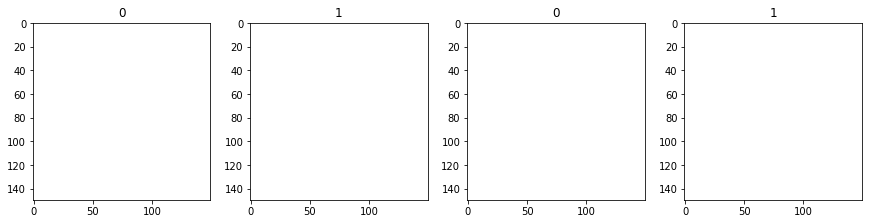

In [24]:
fig, axes = plt.subplots(1, 4, figsize=(12, 4), constrained_layout=True)
axes = axes.ravel()
for i, ex in enumerate(ds.take(4)):
    idx = 31  # take an element of the current batch
    axes[i].imshow(ex[0]['img'].numpy()[idx])
    axes[i].set_title(ex[1]['ctype_label'].numpy()[idx])

# Define NN model

Transfer learning <br>
https://www.pyimagesearch.com/2019/06/24/change-input-shape-dimensions-for-fine-tuning-with-keras/

In [25]:
# ------------------------------------------
# Define TF Datasets for T/V/E
# ------------------------------------------
kwargs = {'batch_size': 32,
          'shuffle': True,
          'augment': False,
          'repeat': False,
          'prefetch': 10,
          'img_dim': 150,
          'seed': None}

ds_tr = get_dataset(tr_tfr_files, **kwargs)
ds_vl = get_dataset(vl_tfr_files, **kwargs)
ds_te = get_dataset(te_tfr_files, **kwargs)

In [26]:
data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(0.1),
    ]
)

In [27]:
base_model = keras.applications.Xception(
    weights="imagenet",  # Load weights pre-trained on ImageNet.
    input_shape=(150, 150, 3),
    include_top=False,
)  # Do not include the ImageNet classifier at the top.

# Freeze the base_model
base_model.trainable = False

# Create new model on top
inputs = keras.Input(shape=(150, 150, 3), name='img')
x = data_augmentation(inputs)  # Apply random data augmentation

# Pre-trained Xception weights requires that input be normalized
# from (0, 255) to a range (-1., +1.), the normalization layer
# does the following, outputs = (inputs - mean) / sqrt(var)
norm_layer = keras.layers.experimental.preprocessing.Normalization()
mean = np.array([127.5] * 3)
var = mean ** 2
# Scale inputs to [-1, +1]
x = norm_layer(x)
norm_layer.set_weights([mean, var])

# The base model contains batchnorm layers. We want to keep them in inference mode
# when we unfreeze the base model for fine-tuning, so we make sure that the
# base_model is running in inference mode here.
x = base_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)  # Regularize with dropout
outputs = keras.layers.Dense(1, name='ctype_label')(x)
model = keras.Model(inputs, outputs)

model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
img (InputLayer)             [(None, 150, 150, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 150, 150, 3)       0         
_________________________________________________________________
normalization (Normalization (None, 150, 150, 3)       7         
_________________________________________________________________
xception (Functional)        (None, 5, 5, 2048)        20861480  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
ctype_label (Dense)          (None, 1)                

In [28]:
# First, clear prior Tensorflow graph to free memory
tf.keras.backend.clear_session()  # slideflow

# loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
loss = {'ctype_label': tf.keras.losses.CategoricalCrossentropy(from_logits=True)}

model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=loss,
    metrics=[keras.metrics.BinaryAccuracy()],
)

epochs = 20
model.fit(ds_tr, epochs=epochs, validation_data=ds_vl)

Epoch 1/20
155/155 [==============================] - 6s 36ms/step - loss: 0.0000e+00 - binary_accuracy: 0.5141 - val_loss: 0.0000e+00 - val_binary_accuracy: 0.5000
Epoch 2/20
155/155 [==============================] - 4s 27ms/step - loss: 0.0000e+00 - binary_accuracy: 0.5152 - val_loss: 0.0000e+00 - val_binary_accuracy: 0.5000
Epoch 3/20
155/155 [==============================] - 4s 27ms/step - loss: 0.0000e+00 - binary_accuracy: 0.5152 - val_loss: 0.0000e+00 - val_binary_accuracy: 0.5000
Epoch 4/20
155/155 [==============================] - 4s 27ms/step - loss: 0.0000e+00 - binary_accuracy: 0.5152 - val_loss: 0.0000e+00 - val_binary_accuracy: 0.5000
Epoch 5/20
155/155 [==============================] - 4s 27ms/step - loss: 0.0000e+00 - binary_accuracy: 0.5152 - val_loss: 0.0000e+00 - val_binary_accuracy: 0.5000
Epoch 6/20
155/155 [==============================] - 4s 27ms/step - loss: 0.0000e+00 - binary_accuracy: 0.5152 - val_loss: 0.0000e+00 - val_binary_accuracy: 0.5000
Epoch 7/20

In [ ]:
# ------------------------------------------
# Define TF2 model - multimodal
# ------------------------------------------  
initializer = 'he_uniform'
batchnorm = True
dr_rate = 0.2

# ---------------------
# GE
# ---------------------
in_ge = Input(shape=(in_dim_ge,), name='in_ge')
units_ge = [800, 500]

x = layers.Dense(units_ge[0], kernel_initializer=initializer, name='ge_dense_0')(in_ge)
if batchnorm:
    x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.Dropout(dr_rate)(x)

x = layers.Dense(units_ge[1], kernel_initializer=initializer, name='ge_dense_1')(x)
if batchnorm:
    x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
out_ge = layers.Dropout(dr_rate)(x)

ge = Model(inputs=in_ge, outputs=out_ge, name='out_ge')

# ---------------------
# DD
# ---------------------
in_dd = Input(shape=(in_dim_dd,), name='in_dd')
units_dd = [995, 700]

x = layers.Dense(units_dd[0], kernel_initializer=initializer, name='dd_dense_0')(in_dd)
if batchnorm:
    x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.Dropout(dr_rate)(x)

x = layers.Dense(units_dd[1], kernel_initializer=initializer, name='dd_dense_1')(x)
if batchnorm:
    x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
out_dd = layers.Dropout(dr_rate)(x)

dd = Model(inputs=in_dd, outputs=out_dd, name='out_dd')

# ---------------------
# IMG
# ---------------------
in_im = Input(shape=(in_dim_im,), name='in_im')

pass
# tf.keras.applications.EfficientNetB3(
#     include_top=True,
#     weights="imagenet",
#     input_tensor=None,
#     input_shape=None,
#     pooling=None,
#     classes=1000,
#     classifier_activation="softmax",
#     **kwargs
# )
pass

# ---------------------
# Merge towers
mrg = layers.concatenate([ge.output, dd.output, im.output], axis=1)
# units_mrg = [1000, 500, 250, 125]  # original
units_mrg = [500, 250, 125]  # fair

x = layers.Dense(units_mrg[0], kernel_initializer=initializer)(mrg)
if batchnorm:
    x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.Dropout(dr_rate)(x)

x = layers.Dense(units_mrg[1], kernel_initializer=initializer)(x)
if batchnorm:
    x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.Dropout(dr_rate)(x)

x = layers.Dense(units_mrg[2], kernel_initializer=initializer)(x)
if batchnorm:
    x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.Dropout(dr_rate)(x)

# x = layers.Dense(units_mrg[3], kernel_initializer=initializer)(x)
# if batchnorm:
#     x = layers.BatchNormalization()(x)
# x = layers.Activation('relu')(x)
# x = layers.Dropout(dr_rate)(x)

# ---------------------
# Output
outputs = layers.Dense(1, activation='relu', name='bin_response')(x)

# ---------------------
# Input --> Output
model = Model(inputs=[in_ge, in_dd, in_im], outputs=[outputs])

if opt_name.lower() == 'adam':
    opt = keras.optimizers.Adam(learning_rate)
else:
    opt = keras.optimizers.SGD(learning_rate, momentum=0.9)
    
model.compile(loss=tf.keras.losses.BinaryCrossentropy(label_smoothing=0),
              optimizer=opt,
              metrics=['mae'])

In [ ]:
# Inputs
input_ge = tf.keras.Input(shape=(GE_LEN,), name='ge_vec')
input_dd = tf.keras.Input(shape=(DD_LEN,), name='dd_vec')
input_im = tf.keras.Input(shape=(GE_LEN,), name='img')

# Hidden
fc = tf.keras.layers.Dense(128, activation='relu', name='dense_1')(input_ge)
fc = tf.keras.layers.Dropout(0.2, name='dropout_1')(fc)
fc = tf.keras.layers.Dense(128, activation='relu', name='dense_2')(fc)
fc = tf.keras.layers.Dropout(0.2, name='dropout_2')(fc)

# Output
ctype_out = tf.keras.layers.Dense(CTYPE_NUM_CLASSES, activation='softmax', name='ctype_label')(fc)
csite_out = tf.keras.layers.Dense(CSITE_NUM_CLASSES, activation='softmax', name='csite_label')(fc)
# ctype_out = tf.keras.layers.Dense(1, activation='softmax', name='ctype_label')(fc)
# csite_out = tf.keras.layers.Dense(1, activation='softmax', name='csite_label')(fc)

# Model
model = tf.keras.Model(inputs=[input_ge], outputs=[ctype_out, csite_out])
# model = tf.keras.Model(inputs=[input_ge], outputs=[csite_out])
model.summary()

# ----------
# Compile
# ----------
# model.compile(optimizer=tf.keras.optimizers.Adam(),
#               loss={'csite_label': tf.keras.losses.categorical_crossentropy},
#               metrics=[tf.keras.metrics.categorical_crossentropy])

model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss={'csite_label': tf.keras.losses.categorical_crossentropy,
                    'ctype_label': tf.keras.losses.categorical_crossentropy},
              metrics=[tf.keras.metrics.categorical_crossentropy])

# model.compile(optimizer=tf.keras.optimizers.Adam(),
#               loss={'csite_label': tf.keras.losses.mean_absolute_error},
#               metrics=[tf.keras.metrics.mean_absolute_error])

# model.compile(optimizer=tf.keras.optimizers.Adam(),
#               loss={'csite_label': tf.keras.losses.mean_absolute_error,
#                     'ctype_label': tf.keras.losses.mean_absolute_error},
#               metrics=[tf.keras.metrics.mean_absolute_error])

In [ ]:
# The choice of categorical_crossentropy vs sparse_categorical_crossentropy depends on the shape of labels depennds
# stackoverflow.com/questions/49161174/tensorflow-logits-and-labels-must-have-the-same-first-dimension
# ================================================================================================================
# history = model.fit(X_train, y_train, epochs=30, validation_data=(X_valid, y_valid))

history = model.fit(ds_train,
                    epochs=20,
                    validation_data=ds_val,
                    verbose=False)

In [5]:
# Divide the df into smaller dfs
n_tfrecords = 5
d = int(data.shape[0]/n_tfrecords)
dfs = []

for i in range(n_tfrecords):
    i0 = i * d
    i1 = (i + 1) * d
    if i == n_tfrecords - 1:
        i1 = None
    dfs.append(data.iloc[i0:i1])
    
[df.shape for df in dfs]

[(403, 2607), (403, 2607), (403, 2607), (403, 2607), (405, 2607)]

In [6]:
# next(dfs[1].iterrows())[1]
# next(dfs[1].iterrows())[1].index
# next(dfs[1].iterrows())[1].values

# item = next(dfs[1].iterrows())[1]
# ge_vec = [value for col_name, value in zip(item.index, item.values) if col_name.startswith('ge_')]
# dd_vec = [value for col_name, value in zip(item.index, item.values) if col_name.startswith('dd_')]
# item['Sample']

In [9]:
# Create tfrecords
# ----------------
# Ourdir
tfr_out = Path.cwd()/'tfr_from_csv'
os.makedirs(tfr_out, exist_ok=True)

# Randomize the dfs
randomize = False
if randomize:
    import random
    random.shuffle(dfs)
    
n_tr_dfs = 4  # num of train tfr files
n_vl_dfs = 1  # num of val tfr files
tr_sz = 0     # counter for training examples
vl_sz = 0     # counter for val examples

for i, df in enumerate(dfs):
    i += 1

    if i <= n_tr_dfs:
        tfr_fname = tfr_out/f'train_{i}.tfrecord'
        tr_sz += df.shape[0]
    else:
        tfr_fname = tfr_out/f'val_{i}.tfrecord'
        vl_sz += df.shape[0]
        
    # Create tfr writer
    writer = tf.io.TFRecordWriter(str(tfr_fname))

    for i, item in df.iterrows():
        # Prefix rna and drug features
        ge_vec = [value for col_name, value in zip(item.index, item.values) if col_name.startswith('ge_')]
        dd_vec = [value for col_name, value in zip(item.index, item.values) if col_name.startswith('dd_')]
        
        ex = tf.train.Example(features=tf.train.Features(
            feature={
                'ge_vec': tf.train.Feature(float_list=tf.train.FloatList(value=ge_vec)),
                'dd_vec': tf.train.Feature(float_list=tf.train.FloatList(value=dd_vec)),
                'Sample': tf.train.Feature(bytes_list=tf.train.BytesList(value=[bytes(item['Sample'], 'utf-8')])),
                'ctype_label': tf.train.Feature(int64_list=tf.train.Int64List(value=[item['ctype_label']])),
                'csite_label': tf.train.Feature(int64_list=tf.train.Int64List(value=[item['csite_label']])),
                'ctype': tf.train.Feature(bytes_list=tf.train.BytesList(value=[bytes(item['ctype'], 'utf-8')])),
                'csite': tf.train.Feature(bytes_list=tf.train.BytesList(value=[bytes(item['csite'], 'utf-8')]))
            }
        ))
 
        writer.write(ex.SerializeToString())

    writer.close()
    
print(f'Train samples {tr_sz}')
print(f'Val samples   {vl_sz}')

calc_examples_in_tfrecord(str(tfr_out/'val_5.tfrecord'))

Train samples 1612
Val samples   405
Number of examples in the tfrecord: 405


In [16]:
fea_spec = {
    'ge_vec': tf.io.FixedLenFeature(shape=(len(ge_vec),), dtype=tf.float32, default_value=None),
    'dd_vec': tf.io.FixedLenFeature(shape=(len(dd_vec),), dtype=tf.float32, default_value=None),    
    'Sample': tf.io.FixedLenFeature(shape=[], dtype=tf.string, default_value=None),
    'ctype_label':  tf.io.FixedLenFeature(shape=[], dtype=tf.int64, default_value=None),
    'csite_label':  tf.io.FixedLenFeature(shape=[], dtype=tf.int64, default_value=None),
    'ctype':  tf.io.FixedLenFeature(shape=[], dtype=tf.string, default_value=None),
    'csite':  tf.io.FixedLenFeature(shape=[], dtype=tf.string, default_value=None),
}

ds = tf.data.TFRecordDataset(str(tfr_out/'train_1.tfrecord'))
ex = next(ds.__iter__())
ex = tf.io.parse_single_example(ex, features=fea_spec)
print(ex['csite'].numpy().decode('UTF-8'))
print(ex['csite_label'].numpy())
print(csite_enc)

digestive/gastrointestinal
1
{'bladder/urothelial': 0, 'digestive/gastrointestinal': 1, 'endocrine and neuroendocrine': 2, 'gynecologic': 3, 'head & neck': 4, 'kidney': 5, 'lung': 6, 'musculoskeletal': 7, 'skin': 8}


### Create tf datasets

In [16]:
# csite_classes = data['simplified_tumor_site'].values.tolist()
# ctype_classes = data['simplified_tumor_type'].values.tolist()
# tt = tf.convert_to_tensor(csite_classes)
tt = tf.convert_to_tensor(list(csite_enc.keys()))
tt = tf.data.Dataset.from_tensor_slices(tt)
for i in tt:
    # tf.print(i)
    print(i)

tf.Tensor(b'bladder/urothelial', shape=(), dtype=string)
tf.Tensor(b'digestive/gastrointestinal', shape=(), dtype=string)
tf.Tensor(b'endocrine and neuroendocrine', shape=(), dtype=string)
tf.Tensor(b'gynecologic', shape=(), dtype=string)
tf.Tensor(b'head & neck', shape=(), dtype=string)
tf.Tensor(b'kidney', shape=(), dtype=string)
tf.Tensor(b'lung', shape=(), dtype=string)
tf.Tensor(b'musculoskeletal', shape=(), dtype=string)
tf.Tensor(b'skin', shape=(), dtype=string)


In [18]:
# class Dataset():
    
#     def __init__(self, filenames):
#         self.filenames = filenames
    
#     def define_fea_spec(fea_spec):
#         self.fea_spec = fea_spec

fea_spec = {
    'ge_vec':      tf.io.FixedLenFeature(shape=(976,), dtype=tf.float32, default_value=None),
    'dd_vec':      tf.io.FixedLenFeature(shape=(1613,), dtype=tf.float32, default_value=None),    
    'Sample':      tf.io.FixedLenFeature(shape=[1], dtype=tf.string, default_value=None),
    'ctype_label': tf.io.FixedLenFeature(shape=[1], dtype=tf.int64, default_value=None),
    'csite_label': tf.io.FixedLenFeature(shape=[1], dtype=tf.int64, default_value=None),
    'ctype':       tf.io.FixedLenFeature(shape=[1], dtype=tf.string, default_value=None),
    'csite':       tf.io.FixedLenFeature(shape=[1], dtype=tf.string, default_value=None),
}    

def read_tfr_example(ex):
    """ Read and parse a single example from a tfrecord. """
    ex = tf.io.parse_single_example(ex, fea_spec)
    
    # Inputs
    ge_vec = tf.cast(ex['ge_vec'], tf.float32)
    dd_vec = tf.cast(ex['dd_vec'], tf.float32)
    inputs = {'ge_vec': ge_vec}
    
    # Outputs
    csite_label = tf.cast(ex['csite_label'], tf.int64)
    ctype_label = tf.cast(ex['ctype_label'], tf.int64)
    
    # One-hot
    csite_label = tf.one_hot(indices=csite_label, depth=CSITE_NUM_CLASSES, on_value=1.0, off_value=0.0)
    ctype_label = tf.one_hot(indices=ctype_label, depth=CTYPE_NUM_CLASSES, on_value=1.0, off_value=0.0)
    
    csite_label = tf.reshape(csite_label, [CSITE_NUM_CLASSES,])
    ctype_label = tf.reshape(ctype_label, [CTYPE_NUM_CLASSES,])    
    
    # Put into dict
#     outputs = {'csite_label': csite_label}
    outputs = {'csite_label': csite_label, 'ctype_label': ctype_label}
    return inputs, outputs


# Train and val filenames
train_filenames = glob(os.path.join(tfr_out, 'train*.tfrecord'))
val_filenames   = glob(os.path.join(tfr_out, 'val*.tfrecord'))

ds = tf.data.TFRecordDataset(filenames=train_filenames)
ds = ds.map(read_tfr_example)

# Take an example
ii = next(ds.take(1).__iter__())
print('Inputs: ', ii[0].keys())
print('Outputs:', ii[1].keys())

# print(ii[0]['ge_vec'].numpy().shape)
for i, k in enumerate(ii[0].keys()):
    print(k, ii[0][k].numpy().shape)
    
# print(ii[1]['csite_label'].numpy())
# print(ii[1]['ctype_label'].numpy())
for i, k in enumerate(ii[1].keys()):
    print(k, ii[1][k].numpy().shape)

Inputs:  dict_keys(['ge_vec'])
Outputs: dict_keys(['csite_label', 'ctype_label'])
ge_vec (976,)
csite_label (9,)
ctype_label (11,)


In [18]:
# read this:  https://www.tensorflow.org/datasets/performances
def get_tfr_dataset(filenames):
    """ Create tf dataset. """
    ds = tf.data.TFRecordDataset(filenames=filenames)
    ds = ds.shuffle(500, reshuffle_each_iteration=True)
    ds = ds.map(read_tfr_example)
    # ds = ds.batch(32, drop_remainder=True)
    ds = ds.batch(32)
    return ds

ds_train = get_tfr_dataset(train_filenames)
ds_val   = get_tfr_dataset(val_filenames)

# Take a sample
ii = next(ds_train.take(1).__iter__())
# ii = next(ds_val.take(1).__iter__())
print('Inputs: ', ii[0].keys())
print('Outputs:', ii[1].keys())

# print(ii[0]['ge_vec'].numpy().shape)
# print(ii[1]['csite_label'].numpy().shape)
# print(ii[1]['ctype_label'].numpy().shape)

# print(ii[0]['ge_vec'].numpy().shape)
for i, k in enumerate(ii[0].keys()):
    print(k, ii[0][k].numpy().shape)
    
# print(ii[1]['csite_label'].numpy())
# print(ii[1]['ctype_label'].numpy())
for i, k in enumerate(ii[1].keys()):
    print(k, ii[1][k].numpy().shape)

Inputs:  dict_keys(['ge_vec'])
Outputs: dict_keys(['csite_label', 'ctype_label'])
ge_vec (32, 976)
csite_label (32, 9)
ctype_label (32, 11)


In [19]:
# def preprocess(ex):
#     ex = tf.io.parse_single_example(ex, features=fea_spec)
#     # sample = ex['Sample'][0].numpy().decode('utf-8')
#     sample = tf.cast(ex['Sample'], tf.string)
#     return sample

# # Train dataset
# ds = tf.data.TFRecordDataset(filenames=train_filenames)
# ds = ds.map(preprocess)
# ds = ds.shuffle(500, reshuffle_each_iteration=True)
# # ds = ds.batch(64)
# ii = next(ds.take(1).__iter__())
# print(ii[0].numpy().decode('utf-8'))

In [20]:
# Toy dataset
# -----------
# def power_two(x):
#     return x**2

# ds = tf.data.Dataset.range(10)
# ds = ds.map(power_two)
# ds = ds.repeat(1)
# ds = ds.shuffle(100, reshuffle_each_iteration=True)
# ds = ds.batch(2)
# for i, item in enumerate(ds):
#     tf.print(item, end=' ')

### Train Keras Type Classifier

In [21]:
import tensorflow as tf

# Inputs
input_ge = tf.keras.Input(shape=(len(ge_vec),), name='ge_vec')

# Hidden
fc = tf.keras.layers.Dense(128, activation='relu', name='dense_1')(input_ge)
fc = tf.keras.layers.Dropout(0.2, name='dropout_1')(fc)
fc = tf.keras.layers.Dense(128, activation='relu', name='dense_2')(fc)
fc = tf.keras.layers.Dropout(0.2, name='dropout_2')(fc)

# Output
ctype_out = tf.keras.layers.Dense(CTYPE_NUM_CLASSES, activation='softmax', name='ctype_label')(fc)
csite_out = tf.keras.layers.Dense(CSITE_NUM_CLASSES, activation='softmax', name='csite_label')(fc)
# ctype_out = tf.keras.layers.Dense(1, activation='softmax', name='ctype_label')(fc)
# csite_out = tf.keras.layers.Dense(1, activation='softmax', name='csite_label')(fc)

# Model
model = tf.keras.Model(inputs=[input_ge], outputs=[ctype_out, csite_out])
# model = tf.keras.Model(inputs=[input_ge], outputs=[csite_out])
model.summary()

# ----------
# Compile
# ----------
# model.compile(optimizer=tf.keras.optimizers.Adam(),
#               loss={'csite_label': tf.keras.losses.categorical_crossentropy},
#               metrics=[tf.keras.metrics.categorical_crossentropy])

model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss={'csite_label': tf.keras.losses.categorical_crossentropy,
                    'ctype_label': tf.keras.losses.categorical_crossentropy},
              metrics=[tf.keras.metrics.categorical_crossentropy])

# model.compile(optimizer=tf.keras.optimizers.Adam(),
#               loss={'csite_label': tf.keras.losses.mean_absolute_error},
#               metrics=[tf.keras.metrics.mean_absolute_error])

# model.compile(optimizer=tf.keras.optimizers.Adam(),
#               loss={'csite_label': tf.keras.losses.mean_absolute_error,
#                     'ctype_label': tf.keras.losses.mean_absolute_error},
#               metrics=[tf.keras.metrics.mean_absolute_error])

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
ge_vec (InputLayer)             [(None, 976)]        0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 128)          125056      ge_vec[0][0]                     
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 128)          0           dense_1[0][0]                    
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 128)          16512       dropout_1[0][0]                  
_______________________________________________________________________________________

In [22]:
# The choice of categorical_crossentropy vs sparse_categorical_crossentropy depends on the shape of labels depennds
# stackoverflow.com/questions/49161174/tensorflow-logits-and-labels-must-have-the-same-first-dimension
# ================================================================================================================
# history = model.fit(X_train, y_train, epochs=30, validation_data=(X_valid, y_valid))

history = model.fit(ds_train,
                    epochs=20,
                    validation_data=ds_val,
                    verbose=False)

In [23]:
result = model.evaluate(ds_val, verbose=False)
dict(zip(model.metrics_names, result))

{'loss': 0.9979113936424255,
 'ctype_label_loss': 0.5338507890701294,
 'csite_label_loss': 0.4640606641769409,
 'ctype_label_categorical_crossentropy': 0.5338507890701294,
 'csite_label_categorical_crossentropy': 0.4640606641769409}

In [24]:
rr = model.predict(ds_val.repeat(1))
if isinstance(rr, list):
    print(rr[0].shape)
    print(rr[1].shape)
else:
    print(rr.shape)

(405, 11)
(405, 9)


In [78]:
for i, item in enumerate(ds_val):
    pass # print(item)
print(i)
print(ii[0]['ge_vec'].shape)
print(ii[1]['csite_label'].shape)
# print(ii[1]['ctype_label'].shape)

11
(32, 976)
(32, 1)


288